<a href="https://colab.research.google.com/github/raulbenitez/EXPERT3D/blob/main/first_steps_image_processing_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Reading an image:


Select an image from your local drive and upload it to google drive:

In [1]:
from google.colab import files # load skimage libraries
import io
uploaded = files.upload()

Saving pneumo.jpg to pneumo.jpg


Read the image and convert to a data matrix with pixel intensities in each color channel:

In [2]:
import skimage as sk # load skimage libraries
from skimage import io
I = sk.io.imread('pneumo.jpg') # read image using imread function

The data matrix has the following dimensions:

In [3]:
I.shape

(867, 1024, 3)

In [ ]:
print('The image has {} x {} pixels and {} color channels'.format(I.shape[0],I.shape[1],I.shape[2]))

The image has 1024 x 1024 pixels and 3 color channels


Visualize the image:

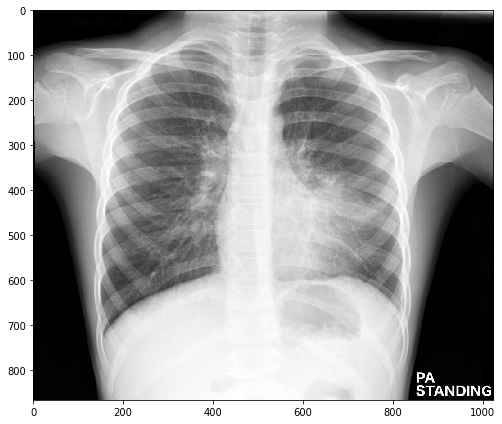

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sk.io.imshow(I) # visualize image using imshow function
sk.io.show() 

Convert the RGB color image to grayscale:

In [5]:
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

Igray = img_as_ubyte(rgb2gray(I)) # convert from RGB to grayscale

In [6]:
Igray.shape

(867, 1024)

In [7]:
Igray.dtype

dtype('uint8')

## 2. Filter an image:

Let's use a simple median filter to remove noise and smooth the image:

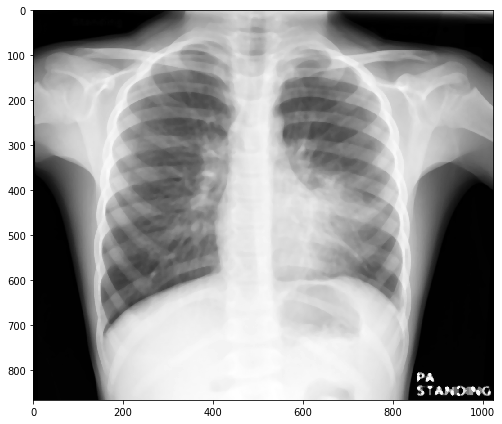

In [9]:
from skimage.filters import median
from skimage.morphology import disk

sel5 = disk(5) # structuring element disk radius 5 pixels
Ifiltered = median(Igray, sel5) #Apply the median filter to obtain the filtered image

fig = plt.figure(figsize=(10,6))
sk.io.imshow(Ifiltered) # visualize image using imshow function
sk.io.show() 

Represent both original and filtered images side by side to compare:

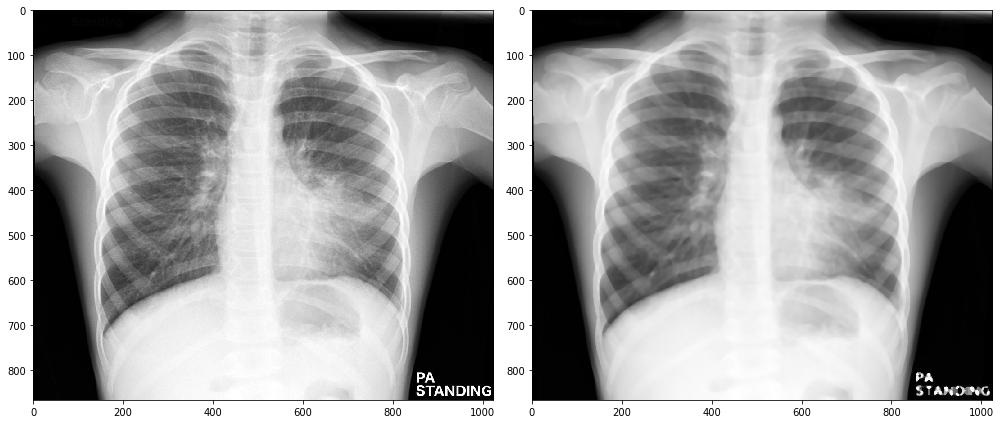

In [11]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(121)
ax = sk.io.imshow(Igray)
ax1 = fig.add_subplot(122)
ax1 = sk.io.imshow(Ifiltered) # visualize image using imshow function
plt.show()

Let's do it with a Gaussian filter

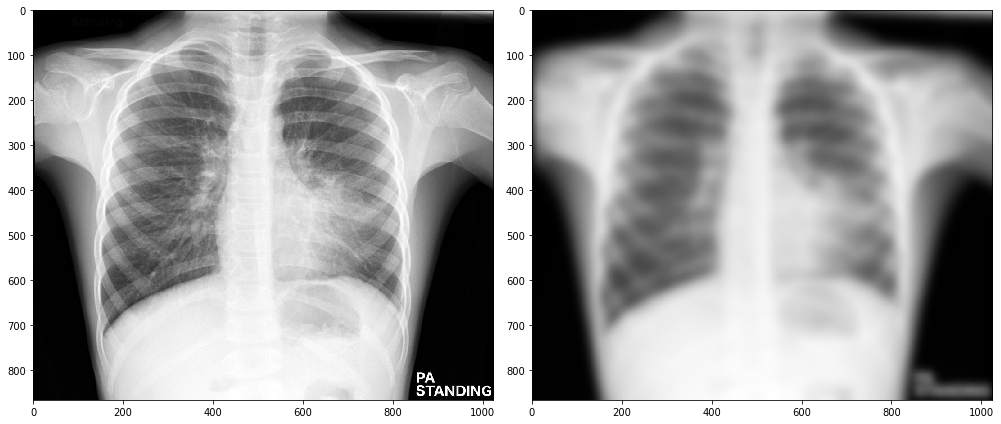

<Figure size 432x288 with 0 Axes>

In [18]:
from skimage.filters import gaussian

IfilteredG = gaussian(Igray,sigma=10) #Apply the gaussian filter to obtain the filtered image

fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(121)
ax = sk.io.imshow(Igray)
ax1 = fig.add_subplot(122)
ax1 = sk.io.imshow(IfilteredG) # visualize image using imshow function
plt.show()
plt.savefig('Gaussian_filter.png')

Let's segment some structures:

Let's start with Otsu:

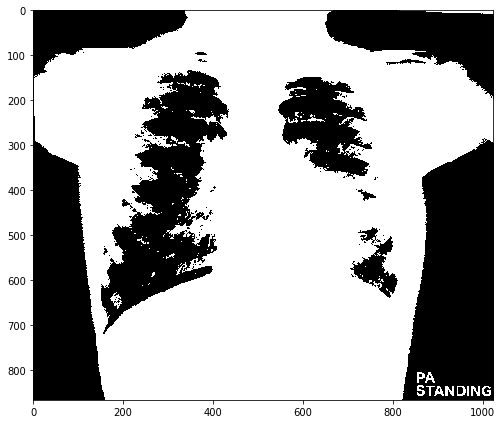

In [20]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(Igray)
binary = Igray > thresh

fig = plt.figure(figsize=(10,6))
sk.io.imshow(binary) # visualize image using imshow function
sk.io.show()

Segmentation using clustering algorithms:

First transform image to 1d array:

In [22]:
import numpy as np

# reshape training image as 1d array:
v_I = Igray.reshape(Igray.shape[0]*Igray.shape[1],1).astype(np.uint8)

v_I.shape

(887808, 1)

Apply kmeans with k=2 clusters:

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


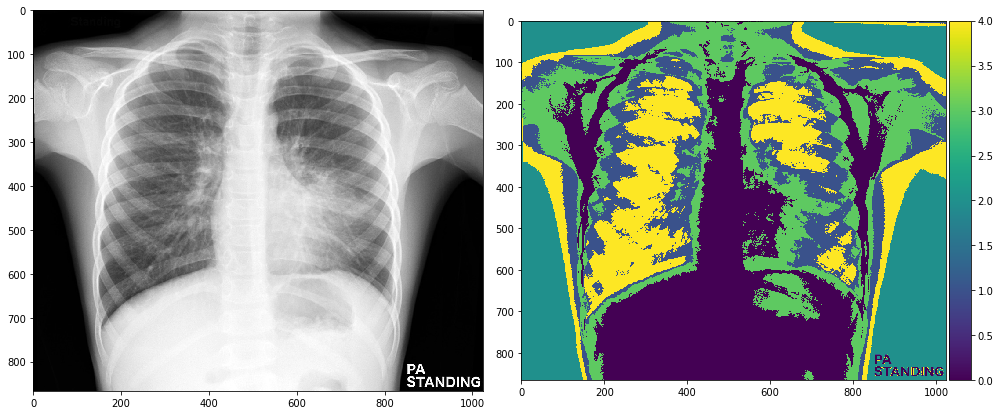

In [24]:
from sklearn.cluster import KMeans
from matplotlib import gridspec

# Fit a Kmeans clustering model with two clusters using training image:
kmeans = KMeans(n_clusters=5, random_state=0).fit(v_I)
v_kmeans = kmeans.predict(v_I)

I_kmeans = np.array(v_kmeans).reshape(Igray.shape[0],Igray.shape[1]).astype(np.uint8) # Shape back result as image 

fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(121)
ax = sk.io.imshow(Igray)
ax1 = fig.add_subplot(122)
ax1 = sk.io.imshow(I_kmeans) # visualize image using imshow function
plt.show()

Let's use Gaussian Mixture Models with statistical model selection in order to determine how many different structures we have in the image:

In [27]:
from sklearn import mixture

#Fit a GMM model with kG gaussians and check the model performance parameter BIC
NMAX = 5
bic = []
aic = []

for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG).fit(v_I)
    bic.append(gmm.bic(v_I)) #cada cop va afegint el bic amb kG+1, així ho tens tot en un vector i pots calcualr el mínim

print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

[10383588.884742126, 10058496.822729165, 9160856.2690494, 9142994.238955868, 9121581.930914538]
...and the winner is GMM model G = 5


Plot hthe histogram of the image


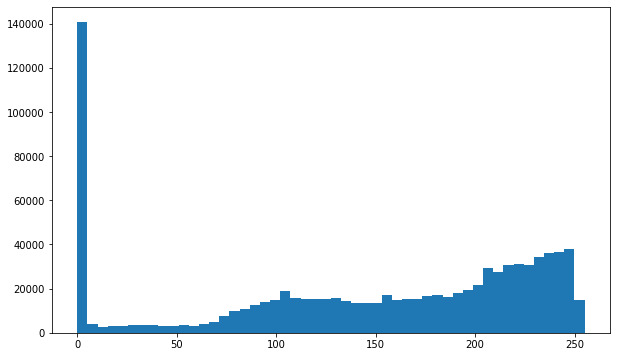

In [30]:
fig = plt.figure(figsize=(10,6))
plt.hist(v_I,50) 
sk.io.show()

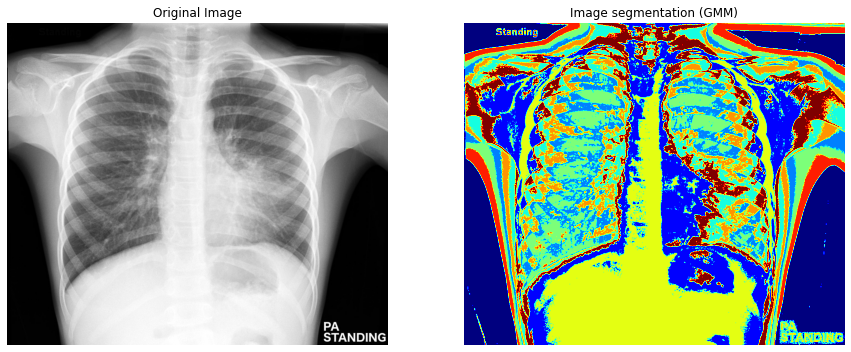

In [26]:
gmmw = mixture.GaussianMixture(n_components=idx_winner).fit(v_I)
v_agg = gmmw.fit_predict(v_I)
I_gmm = np.array(v_agg).reshape(I.shape[0],I.shape[1])# Shape back result as image

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_gmm, cmap=plt.cm.jet)
ax2.set_title('Image segmentation (GMM)')
ax2.set_axis_off()

plt.show()

In [31]:
gmmw.means_

array([[  1.10301434],
       [216.25874172],
       [111.47092697],
       [164.10479144],
       [ 85.76866564],
       [239.80458094],
       [136.74111238],
       [ 31.80995595],
       [190.47902829]])

In [32]:
gmmw.covariances_

array([[[  0.63911167]],

       [[ 85.36802529]],

       [[104.41588386]],

       [[102.29421163]],

       [[145.78276039]],

       [[ 58.08437708]],

       [[103.25572131]],

       [[381.23969307]],

       [[106.02790212]]])

In [ ]:
Get some regional attributes

In [33]:
from skimage.measure import regionprops
import numpy as np 
props = regionprops(I_gmm)

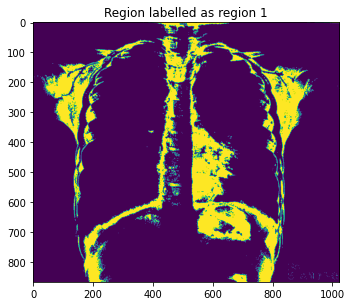

Area of Region 1: 148345 pixels
Centroiod of Region 1: (416.32537665576865, 518.744575145775) 
Eccentricity of Region 1: 0.4871881197346044
Major Axis Length of Region 1: 1006.6787490692599 pixels
Minor Axis Length of Region 1: 879.1295809669435 pixels
Perimeter of Region 1: 33484.78464822248 pixels
Orientation of Region 1: 1.0116229848660228 degrees


In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(I_gmm==1)
ax.set_title('Region labelled as region 1') # set figure title
plt.tight_layout()
plt.show()

print('Area of Region 1: {} pixels'.format(props[0].area))
print('Centroiod of Region 1: {} '.format(props[0].centroid))
print('Eccentricity of Region 1: {}'.format(props[0].eccentricity))
print('Major Axis Length of Region 1: {} pixels'.format(props[0].major_axis_length))
print('Minor Axis Length of Region 1: {} pixels'.format(props[0].minor_axis_length))
print('Perimeter of Region 1: {} pixels'.format(props[0].perimeter))
print('Orientation of Region 1: {} degrees'.format(props[0].orientation))
